Convention: 

Image input type: uint8 (if possible)

Output image: uint8


# Distributions

## Normal

In [0]:
import numpy as np
class MarginalConditionalMultivariateNormal:
  def __init__(self,mu,cov):
    self.cov=cov
    self.dim=cov.shape[0]
    self.mu=mu.reshape((self.dim,1))

  def marginal(self,indices):
    mu = self.mu[indices]
    cov = self.cov[indices,:][:,indices]
    return mu, cov

  def conditional(self,xWithNas):
    xWithNas = xWithNas.reshape((self.dim,1))
    indices = np.isnan(xWithNas).squeeze()
    knownIndices = np.logical_not(indices)
    auxMatrix = np.matmul(self.cov[indices,:][:,knownIndices],
         np.linalg.inv(self.cov[knownIndices,:][:,knownIndices]))
    mu = self.mu[indices] + np.matmul(
        auxMatrix,
        xWithNas[knownIndices] - self.mu[knownIndices])
    cov = self.cov[indices,:][:,indices] - np.matmul(
        auxMatrix,
        self.cov[indices,:][:,knownIndices].T)
    return mu,cov

# mu = np.array([0.0,1.0,2.0])
# cov = np.array([[1.0,0.0,0.5],
#                 [0.0,2.0,0.5],
#                 [0.5,0.5,3.0]])
# print(MarginalConditionalMultivariateNormal(mu,cov).marginal(np.array([True,False,True])))
# print(MarginalConditionalMultivariateNormal(mu,cov).conditional(np.array([[0.0,np.nan,np.nan]])))

In [0]:
import numpy as np
from scipy.stats import multivariate_normal
class MarginalConditionalGmm:
  def __init__(self,pis,mus,covs):
    self.pis = pis
    self.mus = [mu.reshape((-1,)) for mu in mus]
    self.covs = covs
    self.dim = covs[0].shape[0]
    self.k = len(pis)
    self.distributions = [MarginalConditionalMultivariateNormal(self.mus[i],self.covs[i]) for i in range(self.k)]
  
  def marginal(self,indices):
    pis = self.pis.copy()
    mus = [None]*self.k
    covs = [None]*self.k
    for i in range(self.k):
      mus[i], covs[i] = self.distributions[i].marginal(indices) 
    return pis,mus,covs

  def conditional(self,xWithNas,ifErrorReplaceByDistance=True,lambdaIdentity = 0):
    xWithNas = xWithNas.reshape((self.dim,))
    indices = np.isnan(xWithNas).squeeze()
    knownIndices = np.logical_not(indices)
    pis = self.pis.copy()
    mus = [None]*self.k
    covs = [None]*self.k
    for i in range(self.k):
      if self.k != 1:
        auxMu, auxCov = self.distributions[i].marginal(knownIndices)
        
        # prob = tfd.MultivariateNormalFullCovariance(
        #     loc=auxMu.reshape((-1,)),
        #     covariance_matrix=auxCov + np.identity(np.sum(knownIndices))).prob(xWithNas[knownIndices]).numpy()
        
        # prob = multivariate_normal.pdf(
        #     xWithNas[knownIndices],
        #     auxMu.reshape((-1,)),
        #     auxCov + np.identity(np.sum(knownIndices))*lambdaIdentity )
        # print(prob)
        # if prob < 1e-50 or prob > 1e50:
        #   if ifErrorReplaceByDistance:
        #     print("pdf replaced by inverted distance")
        #     prob = 1/np.sqrt(np.sum((auxMu.reshape((-1,)) - xWithNas[knownIndices])**2))
        #   else:
        #     print("pdf replaced by 1 => initial GMM weights")
        #     prob = 1
        pis[i] = self.pis[i] #* prob
        # print( np.sqrt(np.sum((auxMu.reshape((-1,)) - xWithNas[knownIndices])**2)) )
        # import tensorflow_probability as tfp
        # tfd = tfp.distributions
        # fff = tfd.MultivariateNormalFullCovariance(
        #     loc=auxMu.reshape((-1,)),
        #     covariance_matrix=auxCov + np.identity(np.sum(knownIndices))).prob(xWithNas[knownIndices]).numpy()
        # print(fff)
        # pis[i] = self.pis[i] * fff

      mus[i], covs[i] = self.distributions[i].conditional(xWithNas)
    # marginalPis,marginalMus,marginalCovs = self.marginal(knownIndices)
    pis /= np.sum(pis)
    return pis,mus,covs

# mu = np.array([0.0,1.0,2.0])
# cov = np.array([[1.0,0.0,0.5],
#                 [0.0,2.0,0.5],
#                 [0.5,0.5,3.0]])
# pis = np.array([1.0])
# mus=np.array([mu])
# covs=np.array([cov])
# print(MarginalConditionalGmm(pis,mus,covs).marginal(np.array([True,False,True])))
# print(MarginalConditionalGmm(pis,mus,covs).conditional(np.array([[0.0,np.nan,np.nan]])))

## Matrix Normal Distribution

In [0]:
import numpy as np

class MatrixNormalDistribution:
  def __init__(self,M,U,V):
    self.M=M
    self.U=U
    self.V=V
  def _swapRows(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[rangeDestinationTrimmed,:].copy()
      X[rangeDestinationFull,:] = X[rangeSourceFull,:]
      X[rangeSourceTrimmed,:] = aux
    
    # M
    aux = self.M[rangeDestinationTrimmed,:].copy()
    self.M[rangeDestinationFull,:] = self.M[rangeSourceFull,:]
    self.M[rangeSourceTrimmed,:] = aux
    
    # U
    aux = self.U[rangeDestinationTrimmed,:].copy()
    self.U[rangeDestinationFull,:] = self.U[rangeSourceFull,:]
    self.U[rangeSourceTrimmed,:] = aux

    aux = self.U[:,rangeDestinationTrimmed].copy()
    self.U[:,rangeDestinationFull] = self.U[:,rangeSourceFull]
    self.U[:,rangeSourceTrimmed] = aux

    # V - the same
  
  def _swapColumns(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[:,rangeDestinationTrimmed].copy()
      X[:,rangeDestinationFull] = X[:,rangeSourceFull]
      X[:,rangeSourceTrimmed] = aux
    
    # M
    aux = self.M[:,rangeDestinationTrimmed].copy()
    self.M[:,rangeDestinationFull] = self.M[:,rangeSourceFull]
    self.M[:,rangeSourceTrimmed] = aux
    
    # U - the same

    # V
    aux = self.V[:,rangeDestinationTrimmed].copy()
    self.V[:,rangeDestinationFull] = self.V[:,rangeSourceFull]
    self.V[:,rangeSourceTrimmed] = aux

    aux = self.V[rangeDestinationTrimmed,:].copy()
    self.V[rangeDestinationFull,:] = self.V[rangeSourceFull,:]
    self.V[rangeSourceTrimmed,:] = aux

  def moveRectangleToBottomRight(self,topLeftRow,topLeftColumn,
                                 bottomRightRow,bottomRightColumn,X=None):
    # move [topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn]
    nRows = self.M.shape[0]
    nColumns = self.M.shape[1]
    
    rowDiff = bottomRightRow - topLeftRow
    
    rangeSourceFull = range(topLeftRow,bottomRightRow)
    rangeDestinationFull = range(nRows - rowDiff,nRows)

    if bottomRightRow > nRows - rowDiff:
      rangeSourceTrimmed = range(topLeftRow,topLeftRow + nRows - bottomRightRow)
      rangeDestinationTrimmed = range(bottomRightRow,nRows)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapRows(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

    columnDiff = bottomRightColumn - topLeftColumn

    rangeSourceFull = range(topLeftColumn,bottomRightColumn)
    rangeDestinationFull = range(nColumns - columnDiff,nColumns)

    if bottomRightColumn > nColumns - columnDiff:
      rangeSourceTrimmed = range(topLeftColumn,topLeftColumn + nColumns - bottomRightColumn)
      rangeDestinationTrimmed = range(bottomRightColumn,nColumns)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapColumns(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

  def __str__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 
  def __repr__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# distribution.moveRectangleToBottomRight(0,0,4,5)
# print(distribution)

In [0]:
class MarginalConditionalMatrixNormal:

  def __init__(self,distribution):
    self.distribution=distribution

  def marginal(self,indicesRow,indicesColumn):
    return MatrixNormalDistribution(
      M = self.distribution.M[indicesRow,:][:,indicesColumn],
      U = self.distribution.U[indicesRow,:][:,indicesRow],
      V = self.distribution.V[indicesColumn,:][:,indicesColumn]
    )

  def conditional(self,X,row,column):
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution

    auxRow = self.distribution.U[row:,:row].dot(
        np.linalg.inv(self.distribution.U[:row,:row])
    )
    rowDistribution = MatrixNormalDistribution(
        M = self.distribution.M[row:,:] + 
          auxRow.dot(X[:row,:] - self.distribution.M[:row,:]),
        U = self.distribution.U[row:,row:] - 
          auxRow.dot(self.distribution.U[:row,row:]),
        V = self.distribution.V
    )


    auxColumn = np.linalg.inv(self.distribution.V[:column,:column]).dot(
        self.distribution.V[:column,column:]
    )
    columnDistribution = MatrixNormalDistribution(
        M = self.distribution.M[:,column:] + 
          (X[:,:column] - self.distribution.M[:,:column]).dot(auxColumn),
        U = self.distribution.U,
        V = self.distribution.V[column:,column:] - 
          self.distribution.V[column:,:column].dot(auxColumn)
    )

    return rowDistribution, columnDistribution

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

In [0]:
import numpy as np
class MarginalConditionalMatrixGmm:
  def __init__(self,pis,distributions):
    self.pis = pis
    self.numberOfRows = distributions[0].distribution.M.shape[0]
    self.numberOfColumns = distributions[0].distribution.M.shape[1]
    self.k = len(pis)
    self.distributions = distributions
  
  def marginal(self,indicesRow,indicesColumn):
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].marginal(indicesRow,indicesColumn) 
    return pis,distributions

  def conditional(self,X,row,column,lambdaIdentity = 0):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].conditional(X,row,column)
    return pis,distributions

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# # print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

# pis = np.array([1.0])
# distributions = [
#   MarginalConditionalMatrixNormal(
#       MatrixNormalDistribution(M,U,V)
#       )
# ]

# print(MarginalConditionalMatrixGmm(pis,distributions).marginal([True,True,False,True],[True,True,True,True,False]))

# print(MarginalConditionalMatrixGmm(pis,distributions).conditional(X,0,2))

## PixelCNN

-

# Sample Data

In [0]:
import numpy as np
import tensorflow.compat.v1 as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
data = x_train[:5000,:,:]

11493376/11490434 [==============================] - 0s 0us/step


# Fit Distributions

In [0]:
class FitDistribution:
  def fit(self):
    pass
  def _emAlgorithm(self):
    pass
  def _simpleAlgorithm(self):
    pass

## Normal

In [0]:
from sklearn import mixture
class FitNormalDistribution(FitDistribution):
  def __init__(self,data,k,ridge=0.0):
    self.k = k
    self.ridge=ridge
    self.shape = data.shape[1:]
    if data.dtype == "uint8":
      data = data.astype(np.float32)/255.
    data = data.reshape((data.shape[0],-1))
    self.data = data
  
  def fit(self,maxEmIterations=100):
    if self.k == 1:
      return self._simpleAlgorithm()
    return self._emAlgorithm(maxEmIterations)
  
  def _simpleAlgorithm(self):
    mu=np.mean(self.data,axis=0)
    cov = np.cov(self.data.T) + np.identity(self.data.shape[1])*self.ridge
    return self.shape,np.array([1.0],dtype=np.float32),np.array([mu],dtype=np.float32),np.array([cov],dtype=np.float32)
  
  def _emAlgorithm(self,maxEmIterations):
    gmm = mixture.GaussianMixture(n_components=self.k,
                                  max_iter=maxEmIterations,
                                  verbose=1)
    gmm.fit(self.data)
    for i in range(self.k):
      gmm.covariances_[i] = gmm.covariances_[i] + np.identity(self.data.shape[1]) * self.ridge
    return self.shape,gmm.weights_.astype(np.float32),gmm.means_.astype(np.float32),gmm.covariances_.astype(np.float32)

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)

In [0]:
class FitNormalDistributionChannels:
  def __init__(self,data,k,ridge=0.0):
    self.k = k
    self.ridge=ridge
    # if len(data.shape) != 4:
    #   raise Exception("Data is not 3D.")
    self.data = data
  
  def fit(self,maxEmIterations=100):
    nChannels = 1
    if len(self.data.shape) == 4:
      nChannels = self.data.shape[3]

    if nChannels == 1:
      return [FitNormalDistribution(self.data,self.k,self.ridge).fit(maxEmIterations=maxEmIterations)]
    
    rList = [None]*nChannels
    for i in range(nChannels):
      r = FitNormalDistribution(self.data[...,i],self.k,self.ridge).fit(maxEmIterations=maxEmIterations)
      rList[i]=r
    return rList

# fitNormalDistribution = FitNormalDistributionChannels(data,1)
# r1 = fitNormalDistribution.fit()

## Matrix Normal Distribution

In [0]:
# from scipy.stats import matrix_normal
class FitMatrixNormalDistribution(FitDistribution):
  def __init__(self,data,k,maxNumberOfEpochs = 10, threshold = 1e-6, ridge = 0.0):
    self.k = k
    self.maxNumberOfEpochs = maxNumberOfEpochs
    self.threshold = threshold
    self.ridge=ridge
    if data.dtype == "uint8":
      data = data.astype(np.float32)/255.
    self.data = data
  
  def fit(self,maxEmIterations=100):
    if self.k == 1:
      return self._simpleAlgorithm()
    return self._emAlgorithm(maxEmIterations)

  def _simpleAlgorithm(self):
    data = self.data
    M = np.mean(data,axis=0)
    U = np.cov(data.reshape(-1,data.shape[2]).T) + self.ridge*np.identity(M.shape[0]).astype(np.float32) # not used!
    V = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T) + self.ridge*np.identity(M.shape[1]).astype(np.float32)
    if 'bugSwap' not in globals():
      aux = U
      U = V
      V = aux
    for epoch in range(self.maxNumberOfEpochs):
      print(epoch)
      oldU = U
      oldV = V
      U = 0
      V_inv = np.linalg.inv(V)
      for X in data:
        U += 1/(data.shape[2]*data.shape[0])*np.matmul(X - M,
                            np.matmul(
                                V_inv,
                                (X - M).T)) 
      U = U + self.ridge*np.identity(M.shape[0]).astype(np.float32)
      V = 0
      U_inv = np.linalg.inv(U)
      for X in data:
        V += 1/(data.shape[1]*data.shape[0])*np.matmul((X - M).T,
                                                      np.matmul(
                                                          U_inv,
                                                          X - M
                                                      )) 
      V = V + self.ridge*np.identity(M.shape[1]).astype(np.float32)
      error1 = np.linalg.norm(U - oldU)/np.linalg.norm(oldU)
      error2 = np.linalg.norm(V - oldV)/np.linalg.norm(oldV)
      print(error1)
      print(error2)
      if error1 < self.threshold and error2 < self.threshold:
        break
    return np.array([1.0],dtype=np.float32),np.array([M],dtype=np.float32),np.array([U],dtype=np.float32),np.array([V],dtype=np.float32)
  
  def _emAlgorithm(self,maxEmIterations):
    data = self.data
    n = data.shape[0]
    # initialization
    pis = [None]*self.k
    Ms = [None]*self.k
    Us = [None]*self.k
    Vs = [None]*self.k
    simpleU = np.cov(data.reshape(-1,data.shape[2]).T) + self.ridge*np.identity(data.shape[1]).astype(np.float32) # not used!
    simpleV = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T) + self.ridge*np.identity(data.shape[2]).astype(np.float32)
    if 'bugSwap' not in globals():
      aux = simpleU
      simpleU = simpleV
      simpleV = aux
    # E step
    E = np.random.rand(n,self.k)
    for i in range(n):
      E[i,:] = E[i,:]/np.sum(E[i,:])# matrix_normal.pdf(data[i,:,:], mean=M, rowcov=U, colcov=V)
    for iteration in range(maxEmIterations):
      print("EM Iteration: ",iteration)
      # M step
      for j in range(self.k):
        pis[j] = np.mean(E[:,j])
        Ms[j] = np.average(data,axis=0,weights=E[:,j])
        # print(data.reshape(-1,data.shape[2]).T.shape)
        # print(E[:,j].shape)
        # Us[j] = np.cov(data.reshape(-1,data.shape[2]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32) # not used!
        # Vs[j] = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
        if iteration == 0:
          Us[j] = simpleU
          Vs[j] = simpleV
        print("\tcluster ",j)
        for epoch in range(self.maxNumberOfEpochs):
          print("\tU/V Epoch: ", epoch)
          oldU = Us[j]
          oldV = Vs[j]
          U = 0
          V_inv = np.linalg.inv(Vs[j])
          auxSum = np.sum(E[:,j])
          for i in range(data.shape[0]):
            X = data[i,:,:]
            U += 1/(data.shape[2]*auxSum) * E[i,j] * np.matmul(X - Ms[j],
                                np.matmul(
                                    V_inv,
                                    (X - Ms[j]).T)) 
          U = U + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32)
          V = 0
          U_inv = np.linalg.inv(U)
          for i in range(data.shape[0]):
            X = data[i,:,:]
            V += 1/(data.shape[1]*auxSum)*E[i,j]*np.matmul((X - Ms[j]).T,
                                                          np.matmul(
                                                              U_inv,
                                                              X - Ms[j]
                                                          )) 
          V = V + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
          Us[j]=U
          Vs[j]=V
          error1 = np.linalg.norm(U - oldU)/np.linalg.norm(oldU)
          error2 = np.linalg.norm(V - oldV)/np.linalg.norm(oldV)
          print("\t\t",error1)
          print("\t\t",error2)
          if error1 < self.threshold and error2 < self.threshold:
            print("\tU/V: exited via threshold")
            break
        # print("\tU/V: exited via maxIterations")
      newParameters = np.concatenate([np.array(pis),np.array(Ms).reshape((-1,)),np.array(Us).reshape((-1,)),np.array(Vs).reshape((-1,))])
      if iteration != 0:
        error = np.linalg.norm(newParameters - oldParameters)/np.linalg.norm(oldParameters)
        print(error)
        if error < self.threshold:
          print("exited via threshold")
          break
      oldParameters = newParameters
    # print("exited via maxIterations")
        
    return np.array(pis,dtype=np.float32),np.array(Ms,dtype=np.float32),np.array(Us,dtype=np.float32),np.array(Vs,dtype=np.float32)
    # gmm = mixture.GaussianMixture(n_components=self.k)
    # gmm.fit(self.data)
    # for i in range(self.k):
    #   gmm.covariances_[i] = gmm.covariances_[i] + np.identity(self.data.shape[1]) * self.ridge
    # return gmm.weights_.astype(np.float32),gmm.means_.astype(np.float32),gmm.covariances_.astype(np.float32)

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r12 = fitMatrixNormalDistribution.fit()

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r22 = fitMatrixNormalDistribution.fit(maxEmIterations=2)

In [0]:
class FitMatrixNormalDistributionChannels:
  def __init__(self,data,k,maxNumberOfEpochs = 10, threshold = 1e-6, ridge = 0.0):
    self.k = k
    self.maxNumberOfEpochs = maxNumberOfEpochs
    self.threshold = threshold
    self.ridge=ridge
    # if len(data.shape) != 4:
    #   raise Exception("Data is not 3D.")
    self.data = data
  
  def fit(self,maxEmIterations=100):
    nChannels = 1
    if len(self.data.shape) == 4:
      nChannels = self.data.shape[3]
    
    if nChannels == 1:
      return [FitMatrixNormalDistribution(
          self.data,self.k,
          maxNumberOfEpochs = self.maxNumberOfEpochs,
          threshold = self.threshold, 
          ridge = self.ridge
      ).fit(maxEmIterations=maxEmIterations)]

    rList = [None]*nChannels
    for i in range(nChannels):
      r = FitMatrixNormalDistribution(
          self.data[...,i],self.k,
          maxNumberOfEpochs = self.maxNumberOfEpochs,
          threshold = self.threshold, 
          ridge = self.ridge
      ).fit(maxEmIterations=maxEmIterations)
      rList[i] = r
    return rList

## PixelCNN

In [0]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.disable_eager_execution()

class FitPixelCnnlDistribution(FitDistribution):
  def __init__(self,data,k,
               batchSize=16, nEpochs=10, num_resnet=1,
                num_hierarchies=2,
                num_filters=32,
                num_logistic_mix=5,
                dropout_p=.3,
                optimizer = tf.train.AdamOptimizer()):
    tf.reset_default_graph()
    self.k = k
    self.batchSize = batchSize
    self.nEpochs = nEpochs
    if len(data.shape) == 3:
      data = data[...,np.newaxis]
    self.n = data.shape[0]
    self.shape = data.shape[1:]
    self.num_resnet = num_resnet
    self.num_hierarchies = num_hierarchies
    self.num_filters=num_filters
    self.num_logistic_mix=num_logistic_mix
    self.dropout_p=dropout_p
    if data.dtype == "uint8":
      data = data.astype(np.float32)
    else:
      data = (data * 255).astype(np.float32)
    self.dataset = tf.data.Dataset.from_tensor_slices(data)
    self.optimizer = optimizer
  
  def fit(self):
    batch_size = self.batchSize
    train_it = self.dataset.batch(self.batchSize).shuffle(1000).repeat()

    iterator = train_it.make_initializable_iterator()
    # extract an element
    next_element = iterator.get_next()

    # Define a Pixel CNN network
    # dist = tfd.PixelCNN(
    #     image_shape=self.shape,
    #     num_resnet=self.num_resnet,
    #     num_hierarchies=self.num_hierarchies,
    #     num_filters=self.num_filters,
    #     num_logistic_mix=self.num_logistic_mix,
    #     dropout_p=self.dropout_p,
    #     high=255, low=0
    # )

    k = self.k
    pis = tf.nn.softmax(tf.Variable(([0.]*k),dtype=tf.float32))
    distributions = [
        tfd.PixelCNN(
        image_shape=self.shape,
        num_resnet=self.num_resnet,
        num_hierarchies=self.num_hierarchies,
        num_filters=self.num_filters,
        num_logistic_mix=self.num_logistic_mix,
        dropout_p=self.dropout_p,
        high=255, low=0
        ) for _ in range(k)
    ]
    mixture = tfd.Mixture(
      cat=tfd.Categorical(probs=pis),
      components=distributions)

    log_loss = -tf.reduce_sum(mixture.log_prob(next_element))

    train_ops = self.optimizer.minimize(log_loss)

    init_op = tf.global_variables_initializer()

    nBatches = int(self.n/batch_size)
    nEpochs = self.nEpochs

    probs = None
    sess = tf.Session()
    sess.run(init_op)
    sess.run(iterator.initializer)
    for i in range(nEpochs):
      lossEpoch = 0
      # if i == 1:
      # print(len(sess.run(distributions[0].variables)))
      # print(len(sess.run(mixture.variables)))
      # print(sess.run(distributions[0].variables)[10])
      # print(sess.run(mixture.variables)[10])
      for batch in range(nBatches):
        z = sess.run(train_ops)
        loss = sess.run(log_loss)
        probs = sess.run(pis)
        lossEpoch+=loss
      if (i+1) % 1 == 0:
        # import pickle
        # pickle.dump(sess.run(dist.variables),open('drive/My Drive/colab/variables.pkl','wb'))
        print(str(i+1) + " : " + str(lossEpoch))
    result = [sess.run(distributions[j].variables) for j in range(k)]
    arguments = {
        'image_shape':self.shape,
        'num_resnet':self.num_resnet,
        'num_hierarchies':self.num_hierarchies,
        'num_filters':self.num_filters,
        'num_logistic_mix':self.num_logistic_mix,
        'dropout_p':self.dropout_p
    }
      # serialize((arguments,np.array(probs,dtype=np.float32),result,distributions,sess,mixture),
      #           dataName,distributionName,str(k)+"_{}".format(i))
    return arguments,np.array(probs,dtype=np.float32),result,distributions,sess,mixture

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r1 = fitPixelCnnlDistribution.fit()

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()

# Sample from Distribution

In [0]:
class SampleFromDistribution:
  def sample(self,fitDistribution,plot=True):
    pass

## Normal

In [0]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
class SampleFromNormalDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):
    j = np.random.choice(  
     a=list(range(len(fitDistributionResult[1]))),  
     size=1,
     p=fitDistributionResult[1]
    )[0]

    image = multivariate_normal.rvs(
        mean=fitDistributionResult[2][j], 
        cov=fitDistributionResult[3][j]).reshape(fitDistributionResult[0])
    image = np.clip(image,0,1)
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()
# image = SampleFromNormalDistribution().sample(r1)

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)
# image = SampleFromNormalDistribution().sample(r2)

In [0]:
class SampleFromNormalDistributionChannels:
  def sample(self,fitDistributionResult,plot=True):
    nChannels = len(fitDistributionResult)
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = SampleFromNormalDistribution().sample(fitDistributionResult[i],plot=False)
      imageList[i] = image
    
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image

# r1 = FitNormalDistributionChannels(data,1).fit()
# image = SampleFromNormalDistributionChannels().sample(r1)

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()
# image = SampleFromNormalDistribution().sample(r1)

## Matrix Normal Distribution

In [0]:
from scipy.stats import matrix_normal
import matplotlib.pyplot as plt
class SampleFromMatrixNormalDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):

    if 'distributionName' in globals() and 'bugSwap' in globals() and distributionName == "MatrixNormalChannelsFaster" and len(fitDistributionResult[0]) == 1:
      print("swapped")
      fitDistributionResult = list(fitDistributionResult)
      aux = fitDistributionResult[2]
      fitDistributionResult[2] = fitDistributionResult[3]
      fitDistributionResult[3] = aux

    j = np.random.choice(  
     a=list(range(len(fitDistributionResult[0]))),  
     size=1,
     p=fitDistributionResult[0]
    )[0]
    image = matrix_normal.rvs(
        mean=fitDistributionResult[1][j], 
        rowcov=fitDistributionResult[2][j],
        colcov=fitDistributionResult[3][j]).reshape(fitDistributionResult[1][0].shape)
    image = np.clip(image,0,1)
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 
# image = SampleFromMatrixNormalDistribution().sample(r11)

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 
# image = SampleFromMatrixNormalDistribution().sample(r21)

In [0]:
class SampleFromMatrixNormalDistributionChannels:
  def sample(self,fitDistributionResult,plot=True):
    nChannels = len(fitDistributionResult)
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = SampleFromMatrixNormalDistribution().sample(fitDistributionResult[i],plot=False)
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# r11 = FitMatrixNormalDistributionChannels(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# ).fit() 
# image = SampleFromMatrixNormalDistributionChannels().sample(r11)

## PixelCNN

In [0]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

def recoverPixelCnn(arguments,result):
  print("recover")
  tf.reset_default_graph()

  dist = tfd.PixelCNN(
      image_shape=arguments['image_shape'],
      num_resnet=arguments['num_resnet'],
      num_hierarchies=arguments['num_hierarchies'],
      num_filters=arguments['num_filters'],
      num_logistic_mix=arguments['num_logistic_mix'],
      dropout_p=arguments['dropout_p'],
      high=255, low=0
  )

  variables = result

  # with tf.Session() as sess:
  sess=tf.Session()
  sess.run(tf.global_variables_initializer())

  # restore "dist":
  counter=0
  for v in dist.variables:
    sess.run(v.assign(variables[counter]))
    counter+=1
  
  return dist,sess

In [0]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

def recoverMixturePixelCnn(arguments,pis,result):
  tf.reset_default_graph()

  k = len(pis)
  distributions = [
      tfd.PixelCNN(
      image_shape=arguments['image_shape'],
      num_resnet=arguments['num_resnet'],
      num_hierarchies=arguments['num_hierarchies'],
      num_filters=arguments['num_filters'],
      num_logistic_mix=arguments['num_logistic_mix'],
      dropout_p=arguments['dropout_p'],
      high=255, low=0
      ) for _ in range(k)
  ]
  mixture = tfd.Mixture(
    cat=tfd.Categorical(probs=pis),
    components=distributions)

  # with tf.Session() as sess:
  sess=tf.Session()
  sess.run(tf.global_variables_initializer())

  # restore "mixture":
  counter=0
  for j in range(k):
    variables = result[j]
    for i in range(len(variables)):
      sess.run(mixture.variables[counter].assign(variables[i]))
      counter+=1

  return mixture,sess

In [0]:
# %%time
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

import matplotlib.pyplot as plt
class SampleFromPixelCnnDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):
    # j = np.random.choice(  
    #  a=list(range(len(fitDistributionResult[1]))),  
    #  size=1,
    #  p=fitDistributionResult[1]
    # )[0]
    self.fitDistribution=fitDistributionResult
    sess,mixture = self.fitDistribution[4],self.fitDistribution[5]
    if sess is None or sess._closed:
      self.fitDistribution = list(self.fitDistribution)
      mixture,sess=recoverMixturePixelCnn(self.fitDistribution[0],self.fitDistribution[1],self.fitDistribution[2])
      self.fitDistribution[4],self.fitDistribution[5] = sess,mixture
    mixture = self.fitDistribution[5]
    dist=mixture
    # sess=fitDistributionResult[4]
    # if sess is None or sess._closed:
    #   fitDistributionResult = list(fitDistributionResult)
    #   fitDistributionResult[3] = [None]*len(fitDistributionResult[1])
    #   for j2 in range(len(fitDistributionResult[1])):
    #     dist,sess = recoverPixelCnn(fitDistributionResult[0],fitDistributionResult[2][j])
    #     fitDistributionResult[3][j],fitDistributionResult[4] = dist,sess
    # dist=fitDistributionResult[3][j]
    image = sess.run(dist.sample(1))

    # sess.close()

    image = image.squeeze()/255.0
    image = np.clip(image,0,1) # redundant?
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
#                batchSize=16, 
#                nEpochs=1, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r1 = fitPixelCnnlDistribution.fit()
# image = SampleFromPixelCnnDistribution().sample(r1)

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=1, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()

# image = SampleFromPixelCnnDistribution().sample(r2)

# Impute Via Distribution

In [0]:
class ImputeViaDistribution:
  def impute(self,fitDistribution,plot=True):
    pass

## Normal

In [0]:
class ImputeViaNormalDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution,
               ifErrorReplaceByDistance=False,lambdaIdentity = 0):
    self.fitDistribution = fitDistribution
    self.ifErrorReplaceByDistance = ifErrorReplaceByDistance
    self.lambdaIdentity = lambdaIdentity

  def _expectationGmm(self,pis,mus):
    expectation = 0
    for i in range(pis.shape[0]):
      expectation += pis[i] * mus[i]
    return expectation

  def impute(self,imageWithNas,plot=True):
    # HEURISTIC; NOT EXACT
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    image = imageWithNas.copy()
    auxImage = image.reshape((1,-1))
    pis,mus,covs = MarginalConditionalGmm(self.fitDistribution[1],self.fitDistribution[2],self.fitDistribution[3]).conditional(
        auxImage,
        ifErrorReplaceByDistance=self.ifErrorReplaceByDistance,
        lambdaIdentity = self.lambdaIdentity)
    predicted = self._expectationGmm(pis,mus)

    predicted = predicted.squeeze()

    predicted = np.clip(predicted,0.0,1.0)

    image[np.where(np.isnan(image))] = predicted

    image = (image*255.0).astype(np.uint8)

    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# image = data[0,:]
# image = image/255 # IMPORTANT
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# fitNormalDistribution = FitNormalDistribution(data,1,1e-2)
# r1 = fitNormalDistribution.fit()

# imputeViaNormalDistribution = ImputeViaNormalDistribution(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6)

# image = imputeViaNormalDistribution.impute(
#       imageWithNas=image,plot=True
# )

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)

# imputeViaNormalDistribution = ImputeViaNormalDistribution(
#     fitDistribution=r2,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6)

# image = imputeViaNormalDistribution.impute(
#       imageWithNas=image,plot=True
# )

In [0]:
import numpy as np
class ImputeViaNormalDistributionChannels:
  def __init__(self,fitDistribution,
               ifErrorReplaceByDistance=False,lambdaIdentity = 0):
    self.fitDistribution = fitDistribution
    self.ifErrorReplaceByDistance = ifErrorReplaceByDistance
    self.lambdaIdentity = lambdaIdentity

  def impute(self,imageWithNas,plot=True):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaNormalDistribution(
          fitDistribution=self.fitDistribution[i],
          ifErrorReplaceByDistance=self.ifErrorReplaceByDistance,
          lambdaIdentity = self.lambdaIdentity).impute(imageWithNas=imageWithNas[...,i],plot=False)
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# r1 = FitNormalDistributionChannels(data,1,1e-2).fit()

# image = ImputeViaNormalDistributionChannels(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6).impute(
#       imageWithNas=image,plot=True
# )
    

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# r1 = FitNormalDistribution(data,1,1e-2).fit()

# image = ImputeViaNormalDistribution(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6).impute(
#       imageWithNas=image,plot=True
# )

## Matrix Normal Distribution

In [0]:
import numpy as np
# from scipy.stats import matrix_normal
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import matplotlib.pyplot as plt
class ImputeViaMatrixNormalDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution):
    if 'distributionName' in globals() and 'bugSwap' in globals() and distributionName == "MatrixNormalChannelsFaster" and len(fitDistribution[0]) == 1:
      print("swapped")
      fitDistribution = list(fitDistribution)
      aux = fitDistribution[2]
      fitDistribution[2] = fitDistribution[3]
      fitDistribution[3] = aux
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    k = len(self.fitDistribution[0])

    pis = self.fitDistribution[0]
    Ms = [None]*k
    constants = [None]*k
    U_invs = [None]*k
    V_invs = [None]*k
    m = self.fitDistribution[1][0].shape[0]
    n = self.fitDistribution[1][0].shape[1]

    for j in range(k):
      Ms[j] = self.fitDistribution[1][j]
      U = self.fitDistribution[2][j]
      V = self.fitDistribution[3][j]
      
      constants[j] = -m*n/2 * np.log(2*np.pi) - n/2 * np.log(np.linalg.det(U)) - m/2 * np.log(np.linalg.det(V))
      U_invs[j] = np.linalg.inv(U)
      V_invs[j] = np.linalg.inv(V)

    def log_loss_fn(X, k, pis, Ms, U_invs, V_invs, constants):
      result = 0
      for j in range(k):
        result += pis[j]*(constants[j] - 1/2 * tf.linalg.trace(
            tf.linalg.matmul(
                U_invs[j],
                tf.linalg.matmul(
                    X - Ms[j],
                    tf.linalg.matmul(
                        V_invs[j],
                        tf.transpose(X-Ms[j])
                    )
                )
            ))
        )
      return result
    
    tf.reset_default_graph()

    image = imageWithNas
    d0,d1 = np.where(np.isnan(image))
    positions = list(zip(d0,d1))
    result = np.ndarray.tolist(image)
    with tf.variable_scope("na"):
      for i,j in positions:
        result[i][j] = tf.sigmoid(tf.Variable(0.0,dtype=tf.float32)) #np.random.rand(1)[0]
        # result[i][j] = (tf.tanh(tf.Variable(0.0,dtype=tf.float32)) + 1.0)/2.0 #np.random.rand(1)[0]
    result = tf.convert_to_tensor(result)

    log_loss = -log_loss_fn(result, k, pis, Ms, U_invs, V_invs, constants)

    train_ops = optimizer.minimize(log_loss)

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
      sess.run(init_op)
      for i in range(iterations):
        z = sess.run(train_ops)
        loss = sess.run(log_loss)
        image = sess.run(result)
        if i != 0:
          error = np.linalg.norm(image - oldImage)/np.linalg.norm(oldImage)
          if error < threshold:
            break
        oldImage = image
        if (i+1) % verboseAt == 0:
          print(str(i+1) + ": " + str(loss))
          if i!=0:
            print(error)
          # print(matrix_normal.logpdf(image, mean=M, rowcov=U, colcov=V))
          if plot:
            plt.figure()
            plt.imshow(np.squeeze(image),cmap='gray')
            plt.show()
    image = (image*255.0).astype(np.uint8)
    return image


  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    nRows = imageWithNas.shape[0]
    nColumns = imageWithNas.shape[1]
    # distribution = MatrixNormalDistribution(M,U,V)
    k = len(self.fitDistribution[0])
    result = 0
    for j in range(k):
      X = imageWithNas.copy()
      distribution = MatrixNormalDistribution(self.fitDistribution[1][j].copy(),
                                              self.fitDistribution[2][j].copy(),
                                              self.fitDistribution[3][j].copy())
      distribution.moveRectangleToBottomRight(topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,X)

      rowDistribution, columnDistribution = MarginalConditionalMatrixNormal(distribution).conditional(X,
                              nRows-(bottomRightRow - topLeftRow),
                              nColumns-(bottomRightColumn - topLeftColumn))
      _, naColumnDistribution = MarginalConditionalMatrixNormal(rowDistribution).conditional(X[nRows-(bottomRightRow - topLeftRow):,:],
                                  0,
                                  nColumns-(bottomRightColumn - topLeftColumn))
      result += self.fitDistribution[0][j] * naColumnDistribution.M
      ## naRowDistribution.M == naColumnDistribution.M => compute just one of them
      # naRowDistribution, _ = MarginalConditionalMatrixNormal(columnDistribution).conditional(X[:,nColumns-(bottomRightColumn - topLeftColumn):],
      #                             nRows-(bottomRightRow - topLeftRow),
      #                             0)
    
    nans = result
    nans = np.clip(nans, 0.0, 1.0)
    
    initialX = imageWithNas.copy()
    initialX[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = nans

    initialX = (initialX*255.0).astype(np.uint8)

    if plot:
      plt.figure()
      plt.imshow(initialX,cmap="gray")
      plt.show()

    return initialX


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

# image1 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 
# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r21)
# image2 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )
# image3 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

In [0]:
import numpy as np
class ImputeViaMatrixNormalDistributionChannels:
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).impute(
            imageWithNas[...,i],
            plot=False,
            iterations=iterations,
            threshold=threshold,
            optimizer = optimizer,
            verboseAt = verboseAt
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image
  
  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).imputeBlock(
            imageWithNas[...,i],
            topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
            plot=False
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistributionChannels(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistributionChannels(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

## PixelCNN

In [0]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt

tfd = tfp.distributions

class ImputeViaPixelCnnDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def _expectationGmm(self,pis,mus):
    expectation = 0
    for i in range(pis.shape[0]):
      expectation += pis[i] * mus[i]
    return expectation

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    image = imageWithNas.copy()

    if image.dtype == "float32" or image.dtype == "float64":
      image = (image*255.).astype(np.float32)
    elif image.dtype == "uint8":
      image = image.astype(np.float32)
    
    if len(image.shape) == 2:
      image = image[...,np.newaxis]

    sess,mixture = self.fitDistribution[4],self.fitDistribution[5]
    if sess is None or sess._closed:
      self.fitDistribution = list(self.fitDistribution)
      mixture,sess=recoverMixturePixelCnn(self.fitDistribution[0],self.fitDistribution[1],self.fitDistribution[2])
      self.fitDistribution[4],self.fitDistribution[5] = sess,mixture
    mixture = self.fitDistribution[5]

    d0,d1,d2 = np.where(np.isnan(image))
    positions = list(zip(d0,d1,d2))
    result = np.ndarray.tolist(image)
    with tf.variable_scope("na"):
      for i,j,k in positions:
        # result[i][j][k] = tf.sigmoid(tf.Variable(np.random.rand(1)[0],dtype=tf.float32))*255
        result[i][j][k] = tf.sigmoid(tf.Variable(0.0,dtype=tf.float32))*255
    result = tf.convert_to_tensor(result)

    log_loss = -tf.reduce_sum(mixture.log_prob(result))

    train_ops = optimizer.minimize(log_loss, var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="na"))

    local_init_op = tf.initialize_variables(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="na"))

    sess.run(local_init_op)
    sess.run(tf.variables_initializer(optimizer.variables()))

    loss = sess.run(log_loss)
    print(str(0) + ": " + str(loss))
    oldLoss = loss
    if plot:
      image = sess.run(result)
      plt.figure()
      plt.imshow(np.squeeze(image.astype(np.uint8)),cmap='gray')
      plt.show()
    # train
    for i in range(iterations):
      z = sess.run(train_ops)
      loss = sess.run(log_loss)
      if abs(oldLoss - loss)/abs(oldLoss) < threshold:
        image = sess.run(result)
        print("Exited via threshold")
        break
      oldLoss = loss
      if (i+1) % verboseAt == 0:
        print(str(i+1) + ": " + str(loss))
        if plot:
          image = sess.run(result)
          plt.figure()
          plt.imshow(np.squeeze(image.astype(np.uint8)),cmap='gray')
          plt.show()
    # image/=255.
    image = image.astype(np.uint8)
    return image.squeeze()

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# # fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
# #                batchSize=16, 
# #                nEpochs=2, 
# #                num_resnet=1,
# #                num_hierarchies=2,
# #                num_filters=32,
# #                num_logistic_mix=5,
# #                dropout_p=.3,
# #                optimizer = tf.train.AdamOptimizer())
# # r1 = fitPixelCnnlDistribution.fit()

# # img = ImputeViaPixelCnnDistribution(r1).impute(
# #     image,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
# # )

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=2, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()
# r2 = list(r2)
# r2[4] = None

# img = ImputeViaPixelCnnDistribution(r2).impute(
#     image,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
# )

# Serialize/Deserialize

In [0]:
import pickle
def serialize(fitDistribution,dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  # distributionName in {"PixelCnn","Normal" (only for colored images), "NormalChannels","MatrixNormalChannels","MatrixNormalChannelsFaster"}
  if distributionName == "PixelCnn":
    fitDistribution = list(fitDistribution)
    fitDistribution[3],fitDistribution[4],fitDistribution[5]=None,None,None
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  pickle.dump(fitDistribution,open(filename,'wb'))

def deserialize(dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  fitDistribution = pickle.load(open(filename,"rb"))
  if distributionName == "Normal":
    fitDistribution  = [fitDistribution]
  return fitDistribution

# Get Data

## Gray

### MNIST

In [0]:
def getDataMnist():
  import tensorflow.compat.v1 as tf
  mnist = tf.keras.datasets.mnist

  (x_train, y_train),(x_test, y_test) = mnist.load_data()
  dataTrain = x_train[10:]
  dataTest = x_train[:10]

  return dataTrain,dataTest

# dataTrain,dataTest = getDataMnist()

### Celeb-A gray

Source: https://github.com/musyoku/chainer-glow/blob/master/README.md

In [0]:
def getDataCelebaGray():
  import numpy as np
  import os
  directory = "celeba-128x128-images-npy"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1" -O celeba-128x128-images-npy.zip && rm -rf /tmp/cookies.txt
    !unzip celeba-128x128-images-npy.zip
  data = []
  for filename in os.listdir(directory):
    data.append(np.load(directory + "/" + filename))
  data = np.concatenate(data)
  data = data.mean(axis=3).astype(np.uint8)
  dataTrain = data[10:]
  dataTest = data[:10]
  return dataTrain,dataTest

# dataTrain,dataTest = getDataCelebaGray()

## Color

### Cifar-10

In [0]:
def getDataCifar10():
  import tensorflow.compat.v1 as tf
  cifar10 = tf.keras.datasets.cifar10

  (x_train, y_train),(x_test, y_test) = cifar10.load_data()
  dataTrain = x_train[10:]
  dataTest = x_train[:10]

  return dataTrain,dataTest

# dataTrain,dataTest = getDataCifar10()

### Celeb-A

Source: https://github.com/musyoku/chainer-glow/blob/master/README.md

In [0]:
def getDataCeleba():
  import numpy as np
  import os
  directory = "celeba-128x128-images-npy"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1" -O celeba-128x128-images-npy.zip && rm -rf /tmp/cookies.txt
    !unzip celeba-128x128-images-npy.zip
  data = []
  for filename in os.listdir(directory):
    data.append(np.load(directory + "/" + filename))
  data = np.concatenate(data)
  dataTrain = data[10:]
  dataTest = data[:10]
  return dataTrain,dataTest

# dataTrain,dataTest = getDataCeleba()

# Other code

## Add NAs

In [0]:
import numpy as np
def addNasPositions(image,positions):
  for position in positions:
    image[position] = np.nan

def addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn):
  image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan

def addNasRandom(image,probabilityOfSettingPixelToNa):
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if np.random.rand(1)[0] < probabilityOfSettingPixelToNa:
        image[i,j] = np.nan

## dataName to getData...()

In [0]:
dataNameToFunctionGetData = {
    "Mnist":getDataMnist,
    "CelebaGray":getDataCelebaGray,
    "Cifar10":getDataCifar10,
    "Celeba":getDataCeleba
}

## dataName to shape

In [0]:
dataNameToShape = {
    "Mnist":(28,28),
    "CelebaGray":(128,128),
    "Cifar10":(32,32,3),
    "Celeba":(128,128,3)
}

# END OF CODE: RUN UP TO NOW (Ctrl + F8)

# Save models

THE MODELS WILL BE SAVED IN A FOLDER CALLED "serialized-models". 

BE SURE YOU HAVE THIS FOLDER CREATED.

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Gray

### MNIST

In [0]:
dataName = "Mnist"

In [0]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

#### NormalChannels

In [0]:
distributionName = "NormalChannels"

In [0]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Mnist NormalChannels 1
CPU times: user 3.08 s, sys: 438 ms, total: 3.52 s
Wall time: 2.12 s


In [0]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Done  Mnist NormalChannels 2
CPU times: user 12min 24s, sys: 36.4 s, total: 13min
Wall time: 6min 47s


#### MatrixNormalChannelsFaster

In [0]:
distributionName = "MatrixNormalChannelsFaster"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Mnist MatrixNormalChannelsFaster 1
CPU times: user 875 ms, sys: 44 ms, total: 919 ms
Wall time: 924 ms


In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.388693111162896
		 0.6759628391027822
	cluster  1
	U/V Epoch:  0
		 6.363722962457855
		 0.6752360383896137
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 0.7161070592061574
		 0.22625767498391428
	cluster  1
	U/V Epoch:  0
		 0.7168844391813163
		 0.22439979927786108
0.5491463711351335
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.3576147544201628
		 0.21207439409140327
	cluster  1
	U/V Epoch:  0
		 0.3589892648447729
		 0.21143797575930132
0.32138922202724013
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.28384657595238594
		 0.19378104867591153
	cluster  1
	U/V Epoch:  0
		 0.28478375467749417
		 0.1937835754908514
0.2672690534225352
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.24924564053517428
		 0.17806968642715415
	cluster  1
	U/V Epoch:  0
		 0.24996828558552447
		 0.17822223688818126
0.2402099081887939
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.2244857378675002
		 0.16499539761852058
	cluster  1
	U/V Epoch:  0
		 

#### MatrixNormalChannels

In [0]:
distributionName = "MatrixNormalChannels"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
6.375738742494118
0.6756162076445774
1
0.7160769261269768
0.22542669478128008
2
0.35815152476862927
0.21179651173269087
3
0.28422338541500153
0.19378840800197034
4
0.2495372703336701
0.17813971881164214
5
0.22471240630086986
0.1650619035942942
6
0.20500012421437286
0.15401493403580588
7
0.18880026114467824
0.14454475423946883
8
0.17520463337290268
0.1363149769999337
9
0.16360391449310124
0.12907790962940074
Done  Mnist MatrixNormalChannels 1
CPU times: user 38.6 s, sys: 2.01 s, total: 40.7 s
Wall time: 39 s


In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.3785380641074
		 0.6754605340630456
	U/V Epoch:  1
		 0.7201309882176359
		 0.2257119831225978
	U/V Epoch:  2
		 0.36086452266575425
		 0.2119582021615324
	U/V Epoch:  3
		 0.2856580858910803
		 0.19411107895614493
	U/V Epoch:  4
		 0.2505188044199348
		 0.1785232893252688
	U/V Epoch:  5
		 0.22549516972359862
		 0.16544714939469232
	U/V Epoch:  6
		 0.20566845402572675
		 0.15438662022178387
	U/V Epoch:  7
		 0.18939371248758963
		 0.14490360111566422
	U/V Epoch:  8
		 0.1757472732851426
		 0.1366652397137597
	U/V Epoch:  9
		 0.1641119824891498
		 0.12942362556431306
	cluster  1
	U/V Epoch:  0
		 6.373930412072988
		 0.6757202308047797
	U/V Epoch:  1
		 0.7154121570543422
		 0.22480938398572556
	U/V Epoch:  2
		 0.35708518852040566
		 0.21148039679250333
	U/V Epoch:  3
		 0.2835992698634775
		 0.1934699890006943
	U/V Epoch:  4
		 0.24908541060792094
		 0.1778210194773478
	U/V Epoch:  5
		 0.224341366905447
		 0.16475482061636176
	U/V E

#### PixelCnn

In [0]:
distributionName = "PixelCnn"

In [0]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1 : 38561230.68310547
2 : 35980022.74194336
3 : 35277972.971191406
4 : 34867255.20019531
5 : 34428477.02392578
6 : 34168762.556152344
7 : 33793049.96875
8 : 33553372.955322266
9 : 33315559.688476562
10 : 33181402.998291016
Done  Mnist PixelCnn 1
CPU times: user 42min 51s, sys: 6min 28s, total: 49min 20s
Wall time: 37min 49s


In [0]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

1 : 38987088.66455078
2 : 36126116.20800781
3 : 35393819.544433594
4 : 34932879.311035156
5 : 34584941.02392578
6 : 34207860.244140625
7 : 33808444.302734375
8 : 33619242.0559082
9 : 33193544.8203125
10 : 32962282.841552734
Done  Mnist PixelCnn 2
CPU times: user 3h 6min 35s, sys: 42min 17s, total: 3h 48min 53s
Wall time: 2h 40min 7s


### Celeb-A Gray

In [0]:
dataName = "CelebaGray"

In [0]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

--2020-06-11 15:11:28--  https://docs.google.com/uc?export=download&confirm=jAo9&id=197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1
Resolving docs.google.com (docs.google.com)... 172.217.194.101, 172.217.194.139, 172.217.194.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-30-docs.googleusercontent.com/docs/securesc/0p007vk7p1thuhm05kfigeq77m0q4890/4iui3dtieaeb2r10f2knr0pdd6s1r8fu/1591888275000/15153247492295605712/15321227838861245511Z/197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1?e=download [following]
--2020-06-11 15:11:28--  https://doc-0o-30-docs.googleusercontent.com/docs/securesc/0p007vk7p1thuhm05kfigeq77m0q4890/4iui3dtieaeb2r10f2knr0pdd6s1r8fu/1591888275000/15153247492295605712/15321227838861245511Z/197IFPFaj-HS0KEOZS56ycQP-Sz3b3_m1?e=download
Resolving doc-0o-30-docs.googleusercontent.com (doc-0o-30-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connec

#### NormalChannels

In [0]:
distributionName = "NormalChannels"

In [0]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

In [0]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### MatrixNormalChannelsFaster

In [0]:
distributionName = "MatrixNormalChannelsFaster"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  CelebaGray MatrixNormalChannelsFaster 1
CPU times: user 17.9 s, sys: 10.2 s, total: 28.1 s
Wall time: 20.7 s


In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 5.288334134336158
		 0.8998304705042122
	cluster  1
	U/V Epoch:  0
		 5.2568868879350275
		 0.8996614106946423
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 1.1175336961126348
		 0.5856528101533002
	cluster  1
	U/V Epoch:  0
		 1.1116542223014463
		 0.5853052529432626
0.42702090103439133
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.7203558482640682
		 0.3583874051347352
	cluster  1
	U/V Epoch:  0
		 0.7191084321149745
		 0.35909990490481963
0.45568385409605533
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.3875882566646631
		 0.20027484199783482
	cluster  1
	U/V Epoch:  0
		 0.3880938407806619
		 0.2011426983351969
0.3133689660227493
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.2079563507009372
		 0.11473309697581706
	cluster  1
	U/V Epoch:  0
		 0.20863440227994062
		 0.11535826709858656
0.18398635565203106
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.1196309521082156
		 0.07311096262849495
	cluster  1
	U/V Epoch:  0
		 0.1

#### MatrixNormalChannels

In [0]:
distributionName = "MatrixNormalChannels"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
5.272562175745059
0.8997476629337087
1
1.1146331065106962
0.5854827847708285
2
0.7197357484208445
0.3587386482613145
3
0.3878320474954619
0.20070182601846112
4
0.20828621194134297
0.11503971469942327
5
0.11987378827863096
0.07329122126593131
6
0.07718401539231302
0.0533965242782747
7
0.05638835310876518
0.043673498176175475
8
0.04593413410488645
0.0385927503827222
9
0.04036311575892393
0.03565223885176535
Done  CelebaGray MatrixNormalChannels 1
CPU times: user 8min 21s, sys: 1min 46s, total: 10min 7s
Wall time: 5min 10s


In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 5.272169457645963
		 0.8998906001551003
	U/V Epoch:  1
		 1.114178905505885
		 0.5853087823974888
	U/V Epoch:  2
		 0.7195578033402099
		 0.3585778636636727
	U/V Epoch:  3
		 0.38771448130227093
		 0.20059854149632386
	U/V Epoch:  4
		 0.208221972332924
		 0.11499370171424082
	U/V Epoch:  5
		 0.11984940477260303
		 0.07327842493834881
	U/V Epoch:  6
		 0.07718192752064654
		 0.05339951196200849
	U/V Epoch:  7
		 0.056396741721374835
		 0.04368311589902848
	U/V Epoch:  8
		 0.04594677764933635
		 0.03860477121673724
	U/V Epoch:  9
		 0.04037709829284944
		 0.03566483563132329
	cluster  1
	U/V Epoch:  0
		 5.272930608507461
		 0.8996043130993776
	U/V Epoch:  1
		 1.1150147208682448
		 0.585643811056761
	U/V Epoch:  2
		 0.7199021662241328
		 0.3589060460992023
	U/V Epoch:  3
		 0.38796344404968963
		 0.20081659180056438
	U/V Epoch:  4
		 0.20836623628050027
		 0.11509574974118207
	U/V Epoch:  5
		 0.11991051199112639
		 0.07331130371924433


#### PixelCnn

In [0]:
distributionName = "PixelCnn"

In [0]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

In [0]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1 : 1650988814.0625
2 : 1501490462.3125
3 : 1467711102.6875
4 : 1447948647.0625


## Color

### Cifar-10

In [0]:
dataName = "Cifar10"

In [0]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

#### Normal

In [0]:
distributionName = "Normal"

In [0]:
%%time
k = 1
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 Normal 1
CPU times: user 30.6 s, sys: 2.09 s, total: 32.7 s
Wall time: 18 s


In [0]:
%%time
k = 2
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
Initialization converged: True
Done  Cifar10 Normal 2
CPU times: user 1h 45min 32s, sys: 36.2 s, total: 1h 46min 8s
Wall time: 54min 36s


#### NormalChannels

In [0]:
distributionName = "NormalChannels"

In [0]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 NormalChannels 1
CPU times: user 11.2 s, sys: 1.33 s, total: 12.6 s
Wall time: 6.7 s


In [0]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Done  Cifar10 NormalChannels 2
CPU times: user 48min 56s, sys: 1min, total: 49min 56s
Wall time: 25min 50s


#### MatrixNormalChannelsFaster

In [0]:
distributionName = "MatrixNormalChannelsFaster"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 MatrixNormalChannelsFaster 1
CPU times: user 2.82 s, sys: 0 ns, total: 2.82 s
Wall time: 3.04 s


In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.826706084274544
		 0.5030542748873442
	cluster  1
	U/V Epoch:  0
		 6.822900568995525
		 0.5015296236241036
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 0.3826223439923927
		 0.20696424360833274
	cluster  1
	U/V Epoch:  0
		 0.37947034453041883
		 0.20626105022788152
0.18410211817790076
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.08459633985553255
		 0.05633847779841936
	cluster  1
	U/V Epoch:  0
		 0.08368623158838048
		 0.05608559958762762
0.05003172842863084
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.020199958931687356
		 0.013903024220031856
	cluster  1
	U/V Epoch:  0
		 0.019965394686868556
		 0.013824288602655756
0.012483066313618642
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.004734334807834835
		 0.0032038292957885677
	cluster  1
	U/V Epoch:  0
		 0.004672563249999758
		 0.00318046135610841
0.0029538775242260824
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.0009724189774242067
		 0.0005749488189940148
	cluste

#### MatrixNormalChannels

In [0]:
distributionName = "MatrixNormalChannels"

In [0]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
6.824828232262761
0.5022997929416319
1
0.38106266110381837
0.20661602353285893
2
0.08413857392377463
0.0562093093652741
3
0.0200808811128885
0.013862125283363566
4
0.004702740110320784
0.0031915773221436045
5
0.0009640449746494233
0.0005713114697318438
6
0.00016819081605900087
0.0001351717454101009
7
0.0002513918641755024
0.0002626224281885672
8
0.00029480947799104
0.00029807020593032075
9
0.00030589124945422846
0.00030676564604015754
0
7.053235688682664
0.5133249035978619
1
0.3815546794834521
0.20686113650277943
2
0.08474958820598712
0.05655052980151127
3
0.020358057747512797
0.014030220179151395
4
0.004799973311126295
0.0032516460761362258
5
0.0009921983268501963
0.0005877849035201136
6
0.0001727538816664284
0.00013719932314095555
7
0.0002556151043897152
0.00026738667175770864
8
0.0003006328987562416
0.0003040806126636693
9
0.0003122177327191076
0.0003131474929859246
0
5.418561661636594
0.5489056218265258
1
0.40454906654725664
0.2337158346860857
2
0.09942783737793949
0.068866412085

In [0]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.840500369586402
		 0.5017000151931112
	U/V Epoch:  1
		 0.3805110766682127
		 0.20645366413857136
	U/V Epoch:  2
		 0.0839683670049172
		 0.056127654897487056
	U/V Epoch:  3
		 0.020035247037849414
		 0.013832710390702904
	U/V Epoch:  4
		 0.004689442159508638
		 0.0031823032644056446
	U/V Epoch:  5
		 0.000960229974286313
		 0.0005685477382309716
	U/V Epoch:  6
		 0.00016795791467899397
		 0.00013554582020043707
	U/V Epoch:  7
		 0.0002516146069212618
		 0.00026280096550039046
	U/V Epoch:  8
		 0.00029487095133137747
		 0.00029811513024009855
	U/V Epoch:  9
		 0.000305902061165802
		 0.00030677185677790395
	cluster  1
	U/V Epoch:  0
		 6.809136891855794
		 0.5028957585590363
	U/V Epoch:  1
		 0.38158923274986445
		 0.20677085632328684
	U/V Epoch:  2
		 0.08431403262929421
		 0.05629685056897744
	U/V Epoch:  3
		 0.020130055373912978
		 0.01389481590318691
	U/V Epoch:  4
		 0.004717458354087727
		 0.0032020671594988025
	U/V Epoch:  5
		 

#### PixelCnn

In [0]:
distributionName = "PixelCnn"

In [0]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

1 : 460824945.4765625
2 : 411326598.5703125
3 : 398815069.390625
4 : 390794975.81640625
5 : 384975486.4921875
6 : 380089192.703125
7 : 378160151.4453125
8 : 374932205.6953125
9 : 372743693.62109375
10 : 371923177.984375
Done  Cifar10 PixelCnn 1
CPU times: user 39min 22s, sys: 6min 34s, total: 45min 56s
Wall time: 37min 28s


In [0]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

1 : 460086740.21875
2 : 412799574.984375
3 : 399765199.27734375
4 : 391605664.30078125
5 : 386592581.4609375
6 : 381809744.734375
7 : 378823697.671875
8 : 375174982.86328125
9 : 373000381.9765625
10 : 371359343.5
Done  Cifar10 PixelCnn 2
CPU times: user 1h 23min 36s, sys: 15min 1s, total: 1h 38min 37s
Wall time: 1h 10min 16s


### Celeb-A

In [0]:
dataName = "Celeba"

In [0]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

#### Normal

In [0]:
distributionName = "Normal"

In [0]:
%%time
k = 1
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

In [0]:
%%time
k = 2
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### NormalChannels

In [0]:
distributionName = "NormalChannels"

In [0]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitNormalDistribution(dataTrain[...,i],k,ridge = 1e-6).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0 done
1 done
2 done
Done  Celeba NormalChannels 1
CPU times: user 24min 13s, sys: 27.1 s, total: 24min 40s
Wall time: 13min 24s


In [0]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### MatrixNormalChannelsFaster

In [0]:
distributionName = "MatrixNormalChannelsFaster"

In [0]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
      dataTrain[...,i],k,
      maxNumberOfEpochs = 0, # faster, approximate
      threshold = 1e-6, 
      ridge = 1e-6
  ).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0 done
1 done
2 done
Done  Celeba MatrixNormalChannelsFaster 1
CPU times: user 54.3 s, sys: 11.8 s, total: 1min 6s
Wall time: 41 s


In [0]:
%%time
k = 2
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
      dataTrain[...,i],k,
      maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
      threshold = 1e-6, 
      ridge = 1e-6
  ).fit(maxEmIterations=10)
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 4.463271042578113
		 0.9046069410464498
	cluster  1
	U/V Epoch:  0
		 4.450135508236431
		 0.9045219175920498
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 1.1012309938217104
		 0.5903554492482691
	cluster  1
	U/V Epoch:  0
		 1.1000689850948469
		 0.5903590491189665
0.3673340439352718
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.7186681874963576
		 0.36013248051587876
	cluster  1
	U/V Epoch:  0
		 0.7178273072362028
		 0.35978863662421595
0.40921601279653474
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.3873175613423417
		 0.20215159610520564
	cluster  1
	U/V Epoch:  0
		 0.3870404168463002
		 0.20190171409988963
0.2933227188406225
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.20833666795644773
		 0.11641976842565775
	cluster  1
	U/V Epoch:  0
		 0.2083213136965764
		 0.11635343504467352
0.17646277271079966
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.12018146193091489
		 0.0743569141626418
	cluster  1
	U/V Epoch:  0
		 0.1

#### MatrixNormalChannels

In [0]:
distributionName = "MatrixNormalChannels"

In [0]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
    dataTrain[...,i],k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
  ).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
4.4567241592206175
0.9045657316972378
1
1.100690346463115
0.5903627383296163
2
0.7182568318096324
0.35995786640554983
3
0.38717291590110486
0.20202118934731547
4
0.20832106063202466
0.11638138488800868
5
0.12022893267728707
0.0743841305654481
6
0.0776218843003499
0.0542157890669563
7
0.056817498970101826
0.044287982615970035
8
0.046329570527779564
0.03907542587425915
9
0.04072308770188708
0.036053862780171905
0 done
0
5.084620500761454
0.8965446752093881
1
1.1101589144206976
0.5811269303412115
2
0.7119785249938788
0.3536522356556606
3
0.38219092822189876
0.19654152791984952
4
0.2047824980719406
0.11243744697538023
5
0.11788011981449967
0.07186961979063747
6
0.07612536616889837
0.05268644944538905
7
0.05586720559571024
0.04334940331245734
8
0.04570721940597044
0.03846643063118293
9
0.040291466008328
0.03562412019067128
1 done
0
5.2364353399298365
0.9016276128698621
1
1.1266276979678056
0.5840005415809231
2
0.7184255651113586
0.3601616019745251
3
0.386353199141707
0.20180426754074593
4

In [0]:
%%time
# memory efficient
k = 2
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
    dataTrain[...,i],k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
  ).fit(maxEmIterations=10)
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 4.461257399763686
		 0.9049689428074781
	U/V Epoch:  1
		 1.1032200417478426
		 0.5906707547791841
	U/V Epoch:  2
		 0.7207826680198376
		 0.3602856767228844
	U/V Epoch:  3
		 0.38879406274763706
		 0.2022171905007977
	U/V Epoch:  4
		 0.20922533798420978
		 0.11649144798268256
	U/V Epoch:  5
		 0.12071822792967335
		 0.07444876504949363
	U/V Epoch:  6
		 0.07788672682842565
		 0.05425544489671141
	U/V Epoch:  7
		 0.056962948133928624
		 0.04431342859439496
	U/V Epoch:  8
		 0.04641196696462523
		 0.0390925563962887
	U/V Epoch:  9
		 0.04077226841136679
		 0.03606601337544613
	cluster  1
	U/V Epoch:  0
		 4.452208660238257
		 0.9041623495577865
	U/V Epoch:  1
		 1.0981293304888153
		 0.5900473823341889
	U/V Epoch:  2
		 0.7157563822271094
		 0.35964279942216987
	U/V Epoch:  3
		 0.385596028822084
		 0.20184108953029162
	U/V Epoch:  4
		 0.2074521187391272
		 0.11628439931549372
	U/V Epoch:  5
		 0.11976368610914072
		 0.07432892289870272


#### PixelCnn

In [0]:
distributionName = "PixelCnn"

In [0]:
# %%time
# k = 1
# r = FitPixelCnnlDistribution(dataTrain,k,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer()).fit()
# serialize(r,dataName,distributionName,k)
# print("Done ","{} {} {}".format(dataName,distributionName,k))

In [0]:
# %%time
# k = 2
# r = FitPixelCnnlDistribution(dataTrain,k,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer()).fit()
# serialize(r,dataName,distributionName,k)
# print("Done ","{} {} {}".format(dataName,distributionName,k))

# Train a model

## 1. Get Data

Place your data in a variable called "dataTrain". It must have either 0, or 3 channels.

OR

Select from the following.

In [0]:
#@title Pick data
dataName = "Cifar10" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

## 2. Pick distribution and k=the number of distributions. Then run!

In [0]:
#@title Pick distribution and k=the number of distributions. Then run!
distributionName = "NormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
k = 1 #@param {type:"slider", min:1, max:10, step:1}
if distributionName == "Normal":
  if k == 1:
    r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
  else:
    r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
  r = [r]
elif distributionName == "NormalChannels":
  if k == 1:
    r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
  else:
    r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)    
elif distributionName == "MatrixNormalChannelsFaster":
  if k == 1:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 0, # faster, approximate
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit()
  else:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit(maxEmIterations=10)
    
elif distributionName == "MatrixNormalChannels":
  if k == 1:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 10,
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit()
  else:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 10,
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit(maxEmIterations=10)
elif distributionName == "PixelCnn":
  r = FitPixelCnnlDistribution(dataTrain,k,
              batchSize=16, 
              nEpochs=10, 
              num_resnet=1,
              num_hierarchies=2,
              num_filters=32,
              num_logistic_mix=5,
              dropout_p=.3,
              optimizer = tf.train.AdamOptimizer()).fit()

# Sample

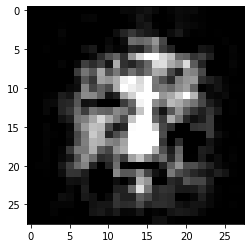

CPU times: user 304 ms, sys: 8.48 ms, total: 313 ms
Wall time: 316 ms


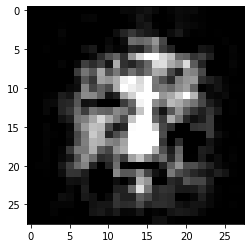

In [50]:
#@title Pick...
%%time

modelLocation = "web" #@param ["web", "memory", "your Google Drive account"]
dataName = "Mnist" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
distributionName = "MatrixNormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
k=1
# k = 1 #@param {type:"slider", min:1, max:2, step:1}
save = True #@param {type:"boolean"}

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Rr0AMwE9jN57EPc8LABRDqaSwDdMjy3d' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Rr0AMwE9jN57EPc8LABRDqaSwDdMjy3d" -O serialized-models-20200615T073536Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200615T073536Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if modelLocation == "web":
  bugSwap = True

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

if distributionName == "Normal" or distributionName == "NormalChannels":
  sampledImage = SampleFromNormalDistributionChannels().sample(r)
elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
  sampledImage = SampleFromMatrixNormalDistributionChannels().sample(r)
elif distributionName == "PixelCnn":
  sampledImage = SampleFromPixelCnnDistribution().sample(r)

plt.imshow(sampledImage,cmap="gray")

if save:
  plt.savefig('sample_{}_{}_{}.eps'.format(dataName,distributionName,k), format='eps')
  plt.savefig('sample_{}_{}_{}.jpg'.format(dataName,distributionName,k), format='jpg')

# Test

## Create test image

### From test image from a dataset

In [0]:
#@title Pick dataset...
dataName = "Mnist" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]

dataTrain,dataTest = dataNameToFunctionGetData[dataName]()
dataTrain[0].shape

(28, 28)

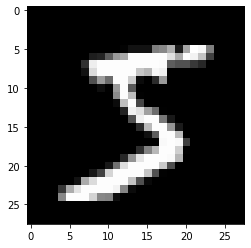

In [0]:
#@title Pick image by number...
import matplotlib.pyplot as plt
imageNumber = 0 #@param {type:"slider", min:0, max:9, step:1}
image = dataTest[imageNumber]
if image.dtype == "uint8":
  image = (image/255.).astype(np.float32)
plt.imshow(image,cmap="gray")
originalImage = image.copy()

### Upload your own image

In [0]:
#@title Pick dataset (to resize the uploaded image to its size)
dataName = "Celeba" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]

desiredImageShape = dataNameToShape[dataName]

Saving capture-paper2.PNG to capture-paper2.PNG
User uploaded file "capture-paper2.PNG" with length 904211 bytes
Uploaded image:


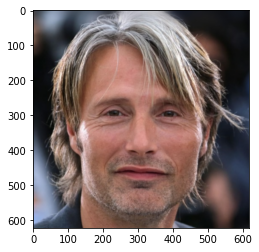

Uploaded image when resized:


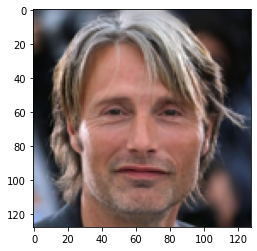

In [0]:
#@title Upload an image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
image = PIL.Image.open(fn)
print("Uploaded image:")
plt.figure()
plt.imshow(image)
plt.show()

if image.mode == "RGBA":
  image = image.convert("RGB")

image = image.resize(desiredImageShape[:2])
image = np.array(image)

if len(desiredImageShape) == 2 and len(image.shape) == 3:
  image = image.mean(2)
if len(desiredImageShape) == 3 and len(image.shape) == 2:
  raise Exception("Dataset is RGB, but your image is Gray. Try again!")

print("Uploaded image when resized:")
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()
image = image/255.
originalImage = image.copy()

## Add NAs to the test image


### Add Block NAs

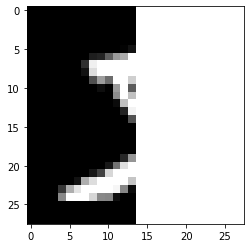

In [0]:
#@title Add Block NAs
topLeftRow =  0#@param {type:"number"}
topLeftColumn =  14#@param {type:"integer"}
bottomRightRow =  28#@param {type:"integer"}
bottomRightColumn =  28#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn)
plt.imshow(image,cmap="gray")

### Add Single-Pixel NA

In [0]:
#@title Add Single-Pixel NA
row =  20#@param {type:"number"}
column =  9#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasPositions(image, [(row,column)])
plt.imshow(image,cmap="gray")

### Add Random NAs

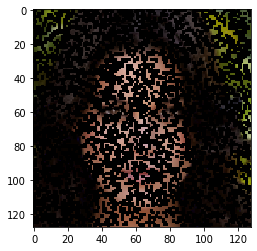

In [0]:
#@title Add Random NAs
probabilityOfSettingPixelToNa = 0.25 #@param {type:"slider", min:0, max:1, step:0.01}
addNasRandom(image,probabilityOfSettingPixelToNa)
import matplotlib.pyplot as plt
plt.imshow(image,cmap="gray")

## View image with NAs

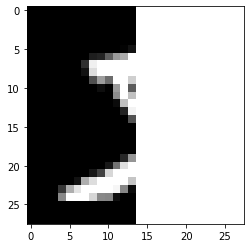

In [0]:
#@title View image with NAs
plt.imshow(image,cmap="gray")

## Inpaint!

### Pick dataset, distribution, k=number of distributions

CPU times: user 776 ms, sys: 132 ms, total: 908 ms
Wall time: 787 ms


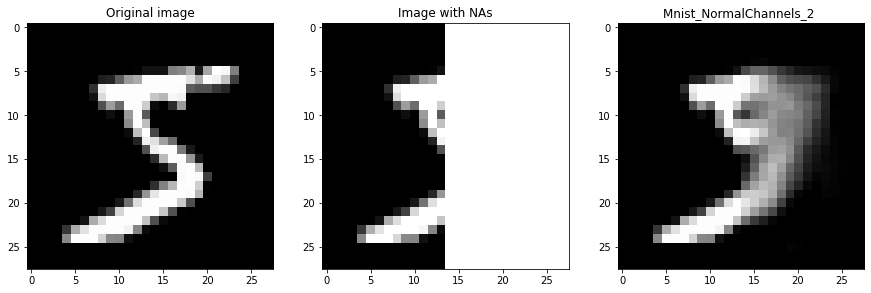

In [0]:
#@title Pick data, distribution, k=number of distributions
%%time

imageWithNas = image

modelLocation = "web" #@param ["web", "memory", "your Google Drive account"]
dataName = "Mnist" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
distributionName = "NormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
imputeABlockForMatrixNormalDistribution = True #@param {type:"boolean"}
k = 1 #@param {type:"slider", min:1, max:2, step:1}
resetInputedImageList = True #@param {type:"boolean"}
save = True #@param {type:"boolean"}

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Rr0AMwE9jN57EPc8LABRDqaSwDdMjy3d' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Rr0AMwE9jN57EPc8LABRDqaSwDdMjy3d" -O serialized-models-20200615T073536Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200615T073536Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if modelLocation == "web":
  bugSwap = True

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

if distributionName == "Normal":
  inpaintedImage = ImputeViaNormalDistribution(
        fitDistribution=r[0],
        ifErrorReplaceByDistance=False,
        lambdaIdentity = 1e-6).impute(
        imageWithNas=imageWithNas,plot=False
    )
elif distributionName == "NormalChannels":
  inpaintedImage = ImputeViaNormalDistributionChannels(
        fitDistribution=r,
        ifErrorReplaceByDistance=False,
        lambdaIdentity = 1e-6).impute(
        imageWithNas=imageWithNas,plot=False
    )
elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
  if imputeABlockForMatrixNormalDistribution:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
        fitDistribution=r).imputeBlock(
              imageWithNas,
              topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
              plot=False
        )
  else:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
      fitDistribution=r).impute(
            imageWithNas,
            plot=False,
            iterations=10000,
            threshold=1e-6,
            optimizer = tf.train.AdamOptimizer(),
            verboseAt = 1000
      )
elif distributionName == "PixelCnn":
  inpaintedImage = ImputeViaPixelCnnDistribution(r).impute(
        imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
    )

if resetInputedImageList:
  if 'inpaintedImages' in globals():
    del inpaintedImages
    del inpaintedTitles

if 'inpaintedImages' not in globals():
  inpaintedImages = []
  inpaintedTitles = []
inpaintedImages.append(inpaintedImage)
inpaintedTitles.append("{}_{}_{} {}".format(dataName,distributionName,k,"Block" if distributionName.startswith("Matrix") and imputeABlockForMatrixNormalDistribution else ""))

%matplotlib inline

fig, ax = plt.subplots(1,2+len(inpaintedImages),figsize=(15,15))
ax[0].title.set_text("Original image")
ax[0].imshow(originalImage,cmap="gray")
ax[1].title.set_text("Image with NAs")
ax[1].imshow(imageWithNas,cmap="gray")
for i in range(len(inpaintedImages)):
  ax[i+2].title.set_text(inpaintedTitles[i])
  ax[i+2].imshow(inpaintedImages[i],cmap="gray")

if save:
  plt.savefig('{}.eps'.format(inpaintedTitles[len(inpaintedTitles)-1]), format='eps')
  plt.savefig('{}.jpg'.format(inpaintedTitles[len(inpaintedTitles)-1]), format='jpg')